In [2]:
import tensorflow as tf
tf.__version__

'2.13.0'

In [3]:
import os
import time
import shutil
import pathlib
import itertools


import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os


drive_directory = '/content/drive/My Drive/Shantho Project/Images'


directory_contents = os.listdir(drive_directory)


print(directory_contents)


['Snow-Covered', 'Clean', 'Physical-Damage', 'Dusty', 'Electrical-damage', 'Bird-drop']


In [6]:
data_dir = '/content/drive/My Drive/Shantho Project/Images'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)


Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [7]:
df

filepaths        labels
0    /content/drive/My Drive/Shantho Project/Images...  Snow-Covered
1    /content/drive/My Drive/Shantho Project/Images...  Snow-Covered
2    /content/drive/My Drive/Shantho Project/Images...  Snow-Covered
3    /content/drive/My Drive/Shantho Project/Images...  Snow-Covered
4    /content/drive/My Drive/Shantho Project/Images...  Snow-Covered
..                                                 ...           ...
871  /content/drive/My Drive/Shantho Project/Images...     Bird-drop
872  /content/drive/My Drive/Shantho Project/Images...     Bird-drop
873  /content/drive/My Drive/Shantho Project/Images...     Bird-drop
874  /content/drive/My Drive/Shantho Project/Images...     Bird-drop
875  /content/drive/My Drive/Shantho Project/Images...     Bird-drop

[876 rows x 2 columns]

In [8]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [9]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size


def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)


test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 694 validated image filenames belonging to 6 classes.
Found 104 validated image filenames belonging to 6 classes.
Found 71 validated image filenames belonging to 6 classes.


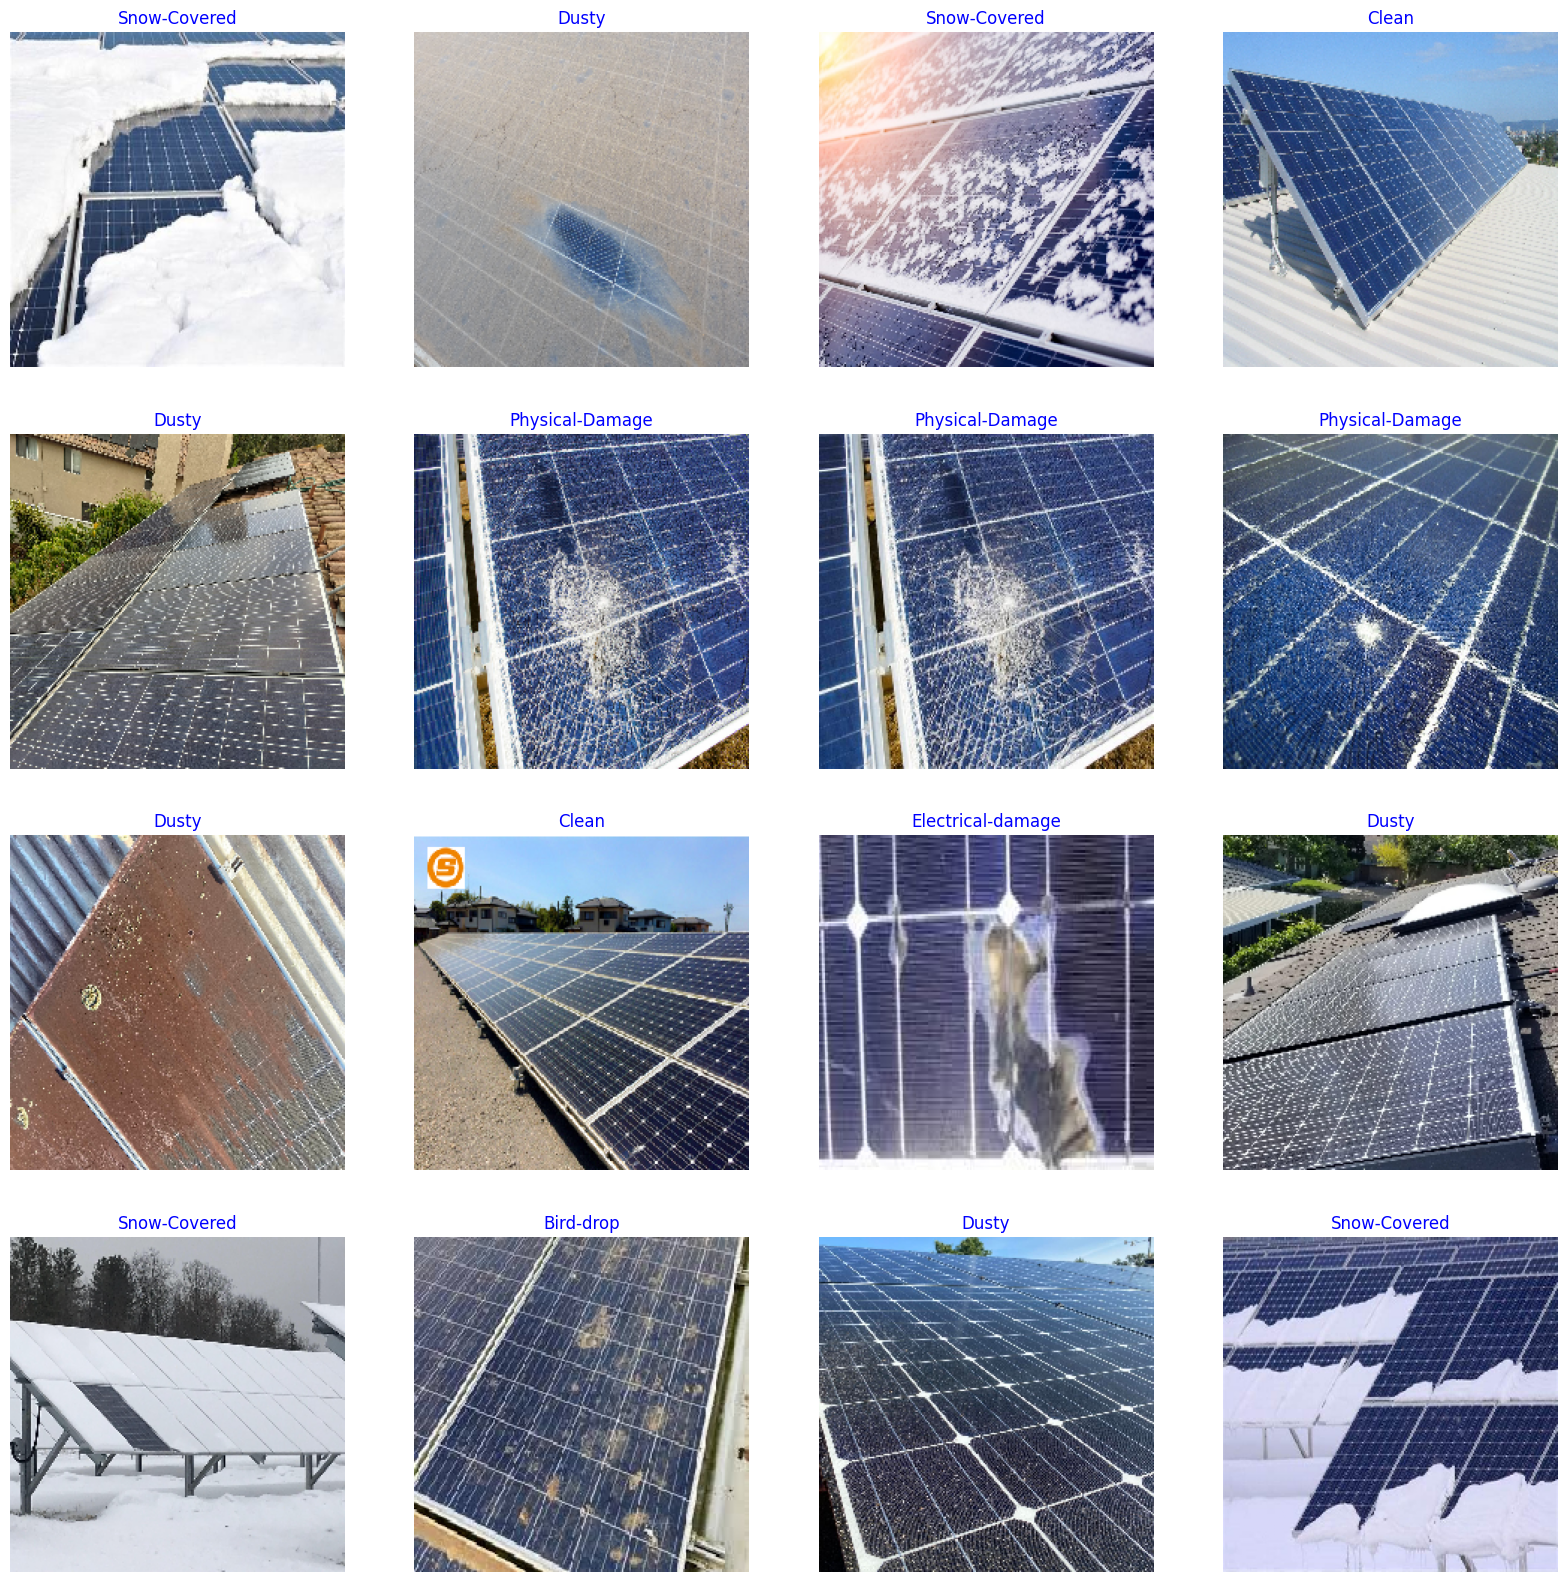

In [10]:
g_dict = train_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_gen)    
plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [11]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) 


base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')


model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

16705208/16705208 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                         

In [12]:
batch_size = 16   # set batch size for training
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/10
44/44 [==============================] - 441s 9s/step - loss: 9.0104 - accuracy: 0.4467 - val_loss: 8.9964 - val_accuracy: 0.5481
Epoch 2/10
44/44 [==============================] - 16s 368ms/step - loss: 7.6070 - accuracy: 0.7464 - val_loss: 7.7566 - val_accuracy: 0.6827
Epoch 3/10
44/44 [==============================] - 16s 364ms/step - loss: 6.8993 - accuracy: 0.8703 - val_loss: 7.1632 - val_accuracy: 0.7596
Epoch 4/10
44/44 [==============================] - 16s 364ms/step - loss: 6.2856 - accuracy: 0.9409 - val_loss: 6.6954 - val_accuracy: 0.7404
Epoch 5/10
44/44 [==============================] - 16s 360ms/step - loss: 5.8856 - accuracy: 0.9539 - val_loss: 6.3068 - val_accuracy: 0.7596
Epoch 6/10
44/44 [==============================] - 19s 441ms/step - loss: 5.4679 - accuracy: 0.9683 - val_loss: 5.9684 - val_accuracy: 0.7692
Epoch 7/10
44/44 [==============================] - 16s 366ms/step - loss: 5.1338 - accuracy: 0.9683 - val_loss: 5.5966 - val_accuracy: 0.7596
E

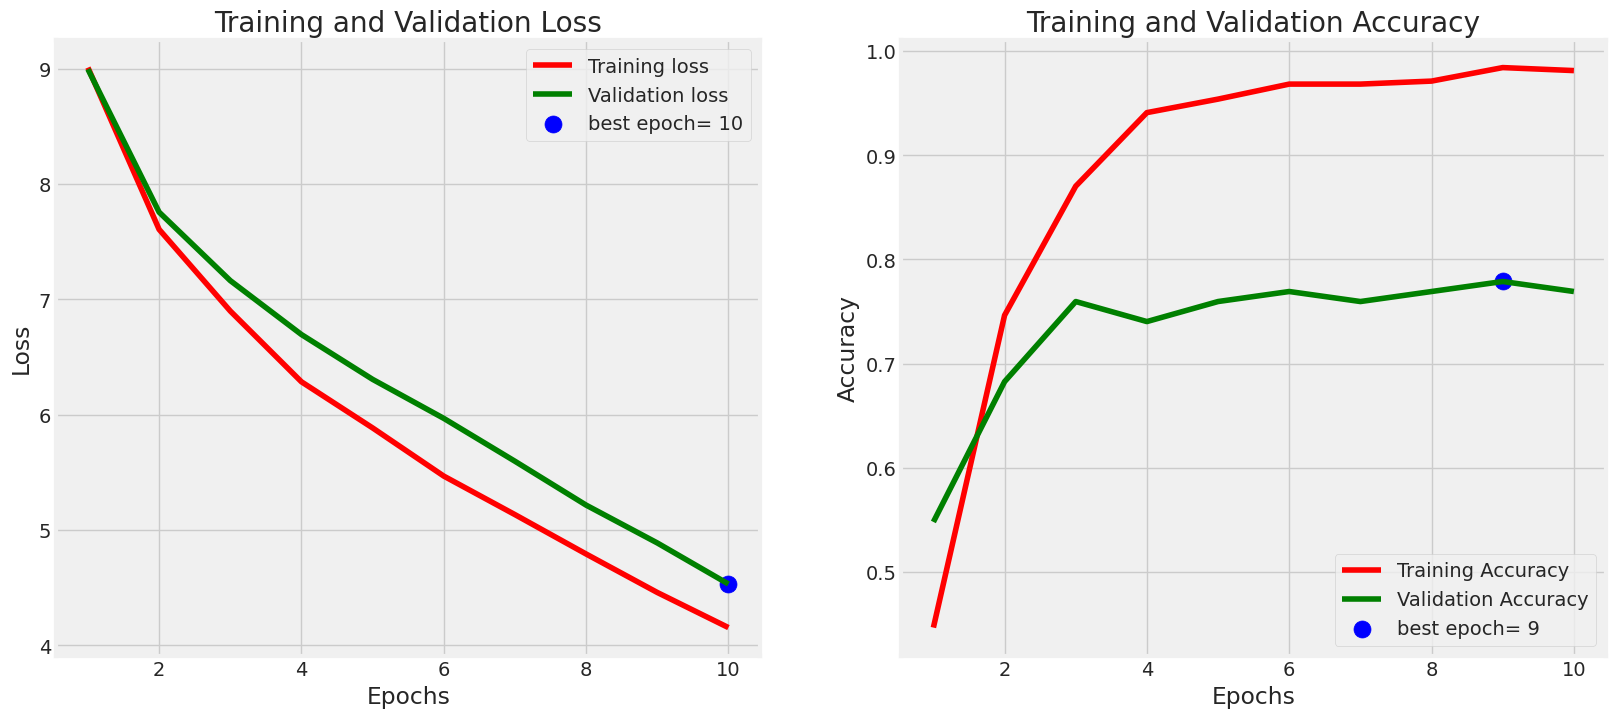

In [13]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [14]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 4s 4s/step - loss: 4.3012 - accuracy: 0.8873
Train Loss:  3.992769479751587
Train Accuracy:  1.0
--------------------
Validation Loss:  4.1977996826171875
Validation Accuracy:  0.9375
--------------------
Test Loss:  4.30118465423584
Test Accuracy:  0.8873239159584045


In [15]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

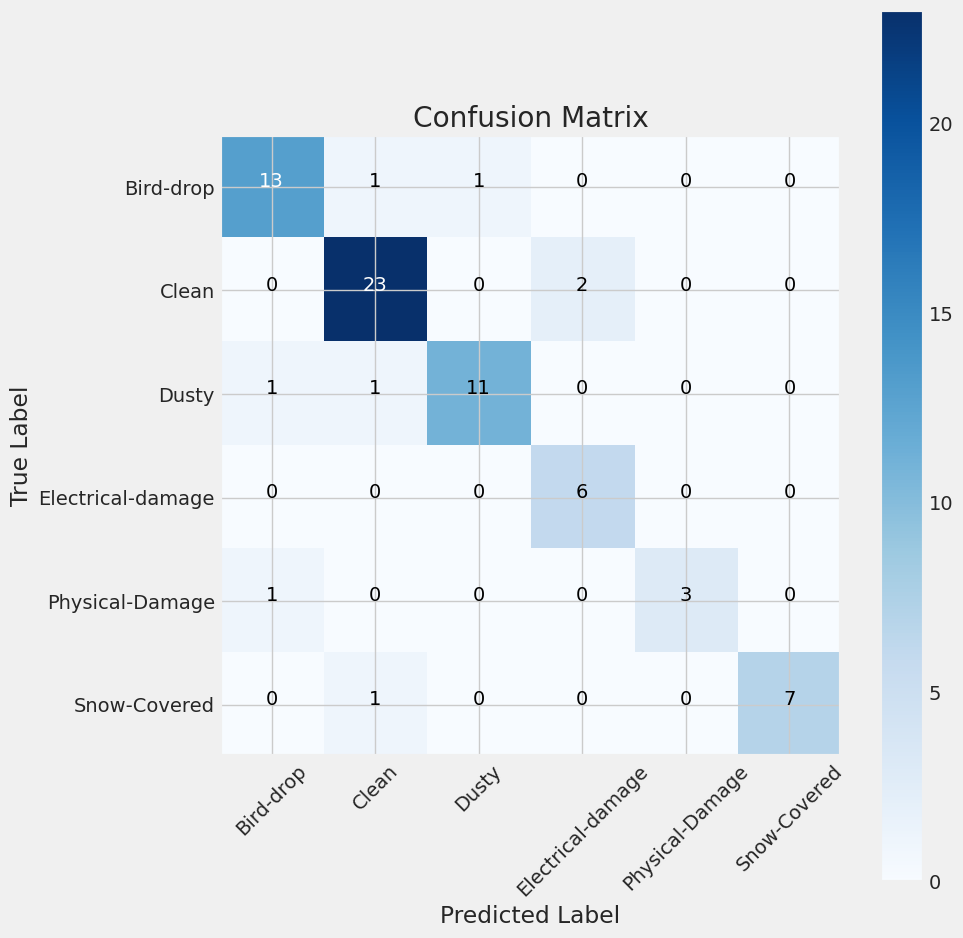

In [16]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())


cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [17]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                   precision    recall  f1-score   support

        Bird-drop       0.87      0.87      0.87        15
            Clean       0.88      0.92      0.90        25
            Dusty       0.92      0.85      0.88        13
Electrical-damage       0.75      1.00      0.86         6
  Physical-Damage       1.00      0.75      0.86         4
     Snow-Covered       1.00      0.88      0.93         8

         accuracy                           0.89        71
        macro avg       0.90      0.88      0.88        71
     weighted avg       0.89      0.89      0.89        71



In [18]:
model_name = model.input_names[0][:-6]
subject = 'Photovoltaic Defects'
acc = test_score[1] * 100
save_path = ''

save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')


weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as efficientnetb0-Photovoltaic Defects-88.73.h5
weights were saved as efficientnetb0-Photovoltaic Defects-weights.h5


In [19]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as Photovoltaic Defects-class_dict.csv
